# Wavelets

https://en.wikipedia.org/wiki/Wavelet

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import scipy.signal

## Gabor wavelet

$$ f(x) = e^{-(x - x_0)^2/a^2}e^{-i k_0(x-x_0)} $$

Also used as (maybe bad?) name for 'modified Morlet', which is just a cosine tapered by a Gaussian.

In [8]:
from collections import namedtuple
def gabor(duration, dt, f, return_t=False):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2, duration/2, dt)

    ft = f * t
    w = np.exp(-2 * ft**2) * np.cos(2 * np.pi * ft)
    
#     gauss = scipy.signal.gaussian()
    w = np.squeeze(w)

    if return_t:
        GaborWavelet = namedtuple('GaborWavelet', ['amplitude', 'time'])
        return GaborWavelet(w, t)
    else:
        return w

In [9]:
f = 35
w, t = gabor(0.128, 0.001, f, return_t=True)

In [10]:
from bruges.filters import ricker
wr, _ = ricker(0.128, 0.001, f, return_t=True)

In [11]:
c = np.cos(2 * f * np.pi * t)

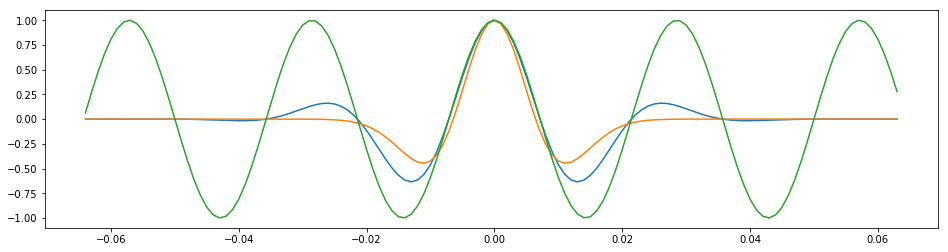

In [12]:
plt.figure(figsize=(16, 4))
plt.plot(t, w)
plt.plot(t, wr)
plt.plot(t, c)

## Sinc and Shannon wavelets

See https://en.wikipedia.org/wiki/Shannon_wavelet

$$ \psi^{(\operatorname{Sha}) }(t) = \operatorname{sinc} \left( \frac {t} {2}\right)\cdot \cos \left( \frac {3 \pi t} {2}\right) $$

or

$$ \psi^{(\operatorname{Sha})}(t)=2 \cdot \operatorname{sinc}(2t - 1)-\operatorname{sinc}(t) $$

where

$$ \operatorname{sinc}(t):= \frac {\sin {\pi t}} {\pi t} $$

First, a pure sinc... I think I made this up.

In [55]:
def generic(func, duration, dt, f, return_t=False, taper='blackman'):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2., duration/2., dt)
    t[t == 0] = 1e-12  # Avoid division by zero.
    f[f == 0] = 1e-12  # Avoid division by zero.
    
    w = np.squeeze(func(t, f))

    if taper:
        tapers = {
            'bartlett': np.bartlett,
            'blackman': np.blackman,
            'hamming': np.hamming,
            'hanning': np.hanning,
            'none': lambda _: 1,
        }
        taper = tapers.get(taper, taper)
        w *= taper(t.size)

    if return_t:
        Wavelet = namedtuple('Wavelet', ['amplitude', 'time'])
        return Wavelet(w, t)
    else:
        return w
    
def sinc(duration, dt, f, return_t=False, taper='blackman'):
    """
    Plain sinc function, tapered.
    """
    func = lambda t_, f_: np.squeeze(np.sin(2*np.pi*f_*t_) / (2*np.pi*f_*t_))
    return generic(func, duration, dt, f, return_t, taper)

import scipy.signal

def cosine(duration, dt, f, return_t=False, taper='gaussian', sigma=None):
    """
    With the default Gaussian window, equivalent to a 'modified Morlet'
    or 'Gabor' wavelet.
    
    Args:
        sigma (float): Width of the default Gaussian window, in seconds.
            Defaults to 1/8 of the duration.
    """
    if sigma is None:
        sigma = duration / 8
    func = lambda t_, f_: np.cos(2 * np.pi * f_ * t_)
    taper = lambda length: scipy.signal.gaussian(length, sigma/dt)
    return generic(func, duration, dt, f, return_t, taper)

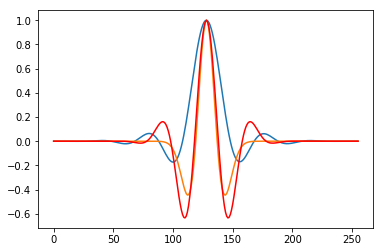

In [73]:
def kaiser(length):
    return np.kaiser(length, beta=10)

plt.plot(sinc(0.256, 0.001, 25, taper=kaiser))
plt.plot(ricker(0.256, 0.001, 25))
plt.plot(gabor(0.256, 0.001, 25), 'r')

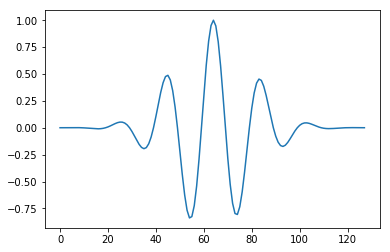

In [66]:
def kaiser(length):
    return np.kaiser(length, beta=10)

plt.plot(cosine(0.128, 0.001, 50, sigma=0.016))

In [65]:
0.128/8

0.016

### Shannon using sincs

In [107]:
def sinc2(duration, dt, f):
    t = np.arange(-duration/2., duration/2., dt)
    return t, np.sinc(0.5*np.pi*f*t)

In [108]:
def shannon2(duration, dt, f):
    t = np.arange(-duration/2., duration/2., dt)
    return t, 2 * np.sinc(2*np.pi*f*t - 1) - np.sinc(2*np.pi*f*t)

In [109]:
sinc(0.512, 0.001, 50, return_t=True)[1].shape

(512,)

In [110]:
sinc2(0.512, 0.001, 50)[0].shape

(512,)

In [111]:
shannon2(0.512, 0.001, 50)[1].shape

(512,)

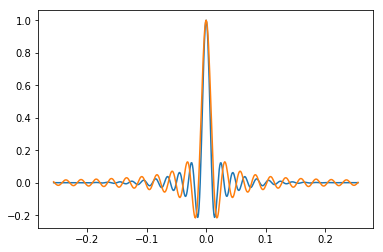

In [112]:
s, t = sinc(0.512, 0.001, 50, return_t=True)

plt.plot(t, s)
plt.plot(*sinc2(0.512, 0.001, 50))
#plt.plot(*shannon2(0.512, 0.001, 50))

In [94]:
def shannon(duration, dt, f):
    f = np.asanyarray(f).reshape(-1, 1)
    t = np.arange(-duration/2., duration/2., dt)
    t[t == 0] = 1e-12  # Avoid division by zero.
    f[f == 0] = 1e-12  # Avoid division by zero.
    return t, np.squeeze(np.sinc(2*np.pi*f*t) * np.cos(3 * np.pi * f * t))

In [223]:
t.shape

(128,)

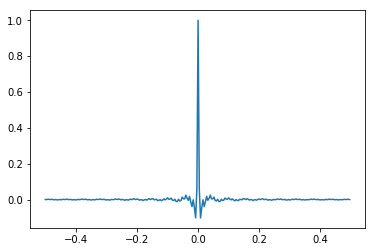

In [224]:
plt.plot(*shannon(1, 0.004, 50))